`Pipelines` are a crucial tool in `Scikit-learn` for streamlining machine learning workflows. They allow you to chain multiple processing steps (like scaling, encoding, imputation) together with a final estimator (like a classifier or regressor) into a single object. This has several benefits:

* **Convenience:** You only need to call `fit` and `predict`/`transform` once on the pipeline object.
* **Preventing Data Leakage:** Ensures that steps like scaling or imputation are fitted only on the training data within each cross-validation fold, preventing information from the validation fold "leaking" into the training process.
* **Parameter Tuning:** Allows you to tune hyperparameters of all steps in the pipeline simultaneously using `GridSearchCV` or `RandomizedSearchCV`.

`ColumnTransformer` is essential when you need to apply different preprocessing steps to different columns of your data (e.g., scaling numerical columns and one-hot encoding categorical columns).


## Scikit-learn: Pipelines & ColumnTransformer

This document covers:

* **Need for Pipelines:** Explains why chaining steps is beneficial, especially for preventing data leakage during cross-validation.
* **Preprocessing Steps:** Defines separate `Pipeline` objects for numerical (imputation + scaling) and categorical (imputation + one-hot encoding) features.
* **ColumnTransformer:** Shows how to combine these different preprocessing pipelines and apply them to the correct columns in the dataset.
* **Full Pipeline:** Demonstrates chaining the `ColumnTransformer` (as the preprocessing step) with a final classifier (e.g., `LogisticRegression`, `SVC`).
* **Training & Evaluation:** Shows that the entire `Pipeline` object is treated as a single estimator – you call `fit` on the raw training data and `predict` on the raw test data. The pipeline handles applying the steps internally.
* **Grid Search with Pipelines:** Illustrates how `GridSearchCV` can tune hyperparameters from any step within the pipeline (including preprocessing steps) by using the `<step_name>__<parameter_name>` syntax.

---

`Pipelines` and `ColumnTransformers` are essential tools for building robust, maintainable, and correct machine learning workflows in `Scikit-learn`, especially when dealing with complex preprocessing requirements.

--- Loading Data ---
Iris data shape: (150, 4)
Digits data shape: (1797, 64)

--- Scaling Data ---
------------------------------
--- Clustering ---

--- a) K-Means ---
K-Means Cluster Labels (first 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Shape of K-Means Centroids: (3, 4)

Silhouette Score for K-Means (K=3): 0.4599
Adjusted Rand Index (vs true labels): 0.6201

(Elbow method plot can help choose K - see commented code)
--------------------

--- b) DBSCAN ---
DBSCAN Cluster Labels (first 30): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Number of clusters found by DBSCAN: 2
Number of noise points found: 4
Silhouette Score for DBSCAN: 0.5217
Adjusted Rand Index (vs true labels): 0.5518
--------------------

--- c) Agglomerative Clustering ---
Agglomerative Cluster Labels (first 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Silhouette Score for Agglomerative (K=3): 0.4599
Adjusted Rand Index (vs true labels): 0.6153
------------------------------
--- Dimensional

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

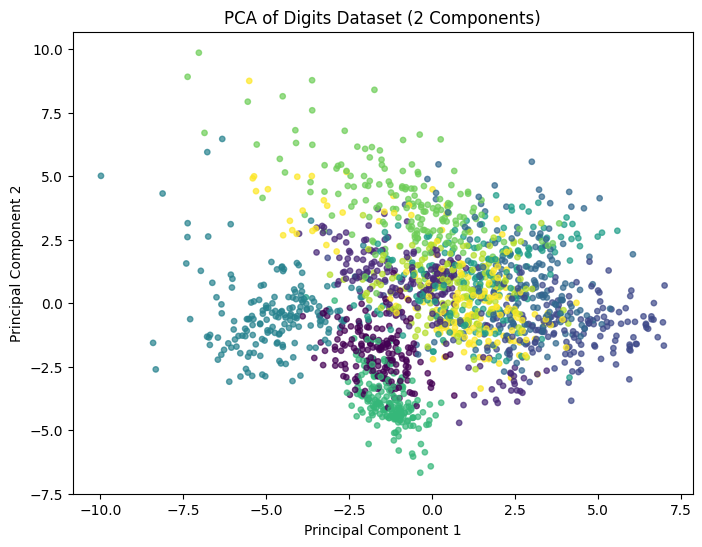

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import StandardScaler
# Clustering Algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# Dimensionality Reduction Algorithms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Evaluation Metrics for Clustering
from sklearn.metrics import silhouette_score, adjusted_rand_score # adjusted_rand_score needs true labels for demo

# --- 1. Concept of Unsupervised Learning ---
# Finding hidden structure in unlabeled data (no target 'y').
# - Clustering: Grouping similar data points together.
# - Dimensionality Reduction: Reducing the number of features while retaining important information.

# --- 2. Load and Prepare Data ---
print("--- Loading Data ---")
# Iris dataset (we'll ignore the labels 'y' for clustering)
iris = load_iris()
X_iris = iris.data
y_iris_true = iris.target # Keep true labels *only* for evaluating clustering later
feature_names_iris = iris.feature_names

# Digits dataset for dimensionality reduction
digits = load_digits()
X_digits = digits.data
y_digits = digits.target # Keep labels for coloring visualization
n_samples, n_features = X_digits.shape
print(f"Iris data shape: {X_iris.shape}")
print(f"Digits data shape: {X_digits.shape}")

# Scale data (important for distance-based algorithms like KMeans, PCA, DBSCAN)
print("\n--- Scaling Data ---")
scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)

scaler_digits = StandardScaler()
X_digits_scaled = scaler_digits.fit_transform(X_digits)
print("-" * 30)


# --- 3. Clustering (sklearn.cluster) ---
# Grouping similar data points.

print("--- Clustering ---")

# a) K-Means Clustering
# Partitions data into K clusters based on minimizing inertia (within-cluster sum of squares).
# Need to specify the number of clusters (K).
print("\n--- a) K-Means ---")
n_clusters_kmeans = 3 # We know Iris has 3 species, let's use K=3

kmeans = KMeans(n_clusters=n_clusters_kmeans,
                init='k-means++', # Smart initialization
                n_init=10,        # Run algorithm 10 times with different centroids
                max_iter=300,     # Max iterations per run
                random_state=42)

# Fit the model and predict cluster labels
kmeans.fit(X_iris_scaled)
cluster_labels_kmeans = kmeans.labels_ # Get cluster assignments for each sample
centroids_kmeans = kmeans.cluster_centers_ # Get cluster centroids

print(f"K-Means Cluster Labels (first 20): {cluster_labels_kmeans[:20]}")
print(f"Shape of K-Means Centroids: {centroids_kmeans.shape}")

# Evaluating K-Means
# Silhouette Score: Measures how similar an object is to its own cluster compared
# to other clusters. Ranges from -1 to 1. Higher values indicate better-defined clusters.
silhouette_avg = silhouette_score(X_iris_scaled, cluster_labels_kmeans)
print(f"\nSilhouette Score for K-Means (K=3): {silhouette_avg:.4f}")

# Adjusted Rand Index (ARI): Compares clustering results against true labels (if known).
# Ranges from -1 to 1. 1 means perfect agreement. Requires true labels.
ari_kmeans = adjusted_rand_score(y_iris_true, cluster_labels_kmeans)
print(f"Adjusted Rand Index (vs true labels): {ari_kmeans:.4f}")

# Choosing K: Elbow Method (visual) - Plot inertia vs K
# inertias = []
# k_range = range(1, 11)
# for k in k_range:
#     kmeans_k = KMeans(n_clusters=k, n_init=10, random_state=42)
#     kmeans_k.fit(X_iris_scaled)
#     inertias.append(kmeans_k.inertia_)
# plt.figure(figsize=(7,4))
# plt.plot(k_range, inertias, marker='o')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Inertia')
# plt.xticks(k_range)
# plt.grid(True)
# plt.show()
print("\n(Elbow method plot can help choose K - see commented code)")
print("-" * 20)


# b) DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
# Finds core samples of high density and expands clusters from them.
# Good for arbitrarily shaped clusters and identifying outliers (noise).
# Doesn't require specifying K, but needs `eps` (max distance between samples)
# and `min_samples` (number of samples in neighborhood).
print("\n--- b) DBSCAN ---")
dbscan = DBSCAN(eps=0.8, min_samples=5) # Parameters eps and min_samples often require tuning
cluster_labels_dbscan = dbscan.fit_predict(X_iris_scaled) # fit_predict combines fit and label prediction

# Cluster label -1 indicates noise points
print(f"DBSCAN Cluster Labels (first 30): {cluster_labels_dbscan[:30]}")
n_clusters_dbscan = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise = list(cluster_labels_dbscan).count(-1)
print(f"\nNumber of clusters found by DBSCAN: {n_clusters_dbscan}")
print(f"Number of noise points found: {n_noise}")

# Evaluate DBSCAN (if clusters were found)
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(X_iris_scaled, cluster_labels_dbscan)
    print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
    ari_dbscan = adjusted_rand_score(y_iris_true, cluster_labels_dbscan)
    print(f"Adjusted Rand Index (vs true labels): {ari_dbscan:.4f}")
else:
    print("Not enough clusters found by DBSCAN for evaluation.")
print("-" * 20)


# c) Agglomerative Clustering (Hierarchical Clustering)
# Builds a hierarchy of clusters (bottom-up).
# Need to specify `n_clusters` or distance thresholds (`distance_threshold`).
print("\n--- c) Agglomerative Clustering ---")
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward') # linkage: 'ward', 'complete', 'average', 'single'
cluster_labels_agg = agg_clustering.fit_predict(X_iris_scaled)

print(f"Agglomerative Cluster Labels (first 20): {cluster_labels_agg[:20]}")

silhouette_agg = silhouette_score(X_iris_scaled, cluster_labels_agg)
print(f"\nSilhouette Score for Agglomerative (K=3): {silhouette_avg:.4f}")
ari_agg = adjusted_rand_score(y_iris_true, cluster_labels_agg)
print(f"Adjusted Rand Index (vs true labels): {ari_agg:.4f}")
# Can also plot dendrograms using scipy.cluster.hierarchy
print("-" * 30)


# --- 4. Dimensionality Reduction ---
# Reducing the number of features. Useful for visualization, noise reduction,
# or speeding up subsequent algorithms.

print("--- Dimensionality Reduction ---")

# a) PCA (Principal Component Analysis) (sklearn.decomposition)
# Finds principal components (linear combinations of original features)
# that capture the maximum variance in the data.
print("\n--- a) PCA ---")
# Reduce digits data (64 features) to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42) # Reduce to 2 principal components
X_digits_pca = pca.fit_transform(X_digits_scaled) # Fit and transform

print(f"Original Digits shape: {X_digits_scaled.shape}")
print(f"Shape after PCA (n_components=2): {X_digits_pca.shape}")

# Explained Variance Ratio: Percentage of variance captured by each component
print(f"Explained Variance Ratio per component: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance (2 components): {pca.explained_variance_ratio_.sum():.4f}")

# Visualize the reduced data (colored by true digit label)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_digits_pca[:, 0], X_digits_pca[:, 1], c=y_digits, cmap='viridis', s=15, alpha=0.7)
plt.title('PCA of Digits Dataset (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=digits.target_names)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()
print("Generated PCA visualization.")
print("-" * 20)

# b) t-SNE (t-distributed Stochastic Neighbor Embedding) (sklearn.manifold)
# Primarily used for *visualization* of high-dimensional data in 2D or 3D.
# Tries to preserve local structure (neighbor relationships). Computationally intensive.
print("\n--- b) t-SNE (for visualization) ---")
# Reduce digits data to 2 dimensions using t-SNE
# Perplexity relates to the number of nearest neighbors considered.
# n_iter controls the number of optimization iterations.
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
print("Running t-SNE (can take a moment)...")
X_digits_tsne = tsne.fit_transform(X_digits_scaled) # Use scaled data
print("t-SNE finished.")

print(f"Shape after t-SNE (n_components=2): {X_digits_tsne.shape}")

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
scatter_tsne = plt.scatter(X_digits_tsne[:, 0], X_digits_tsne[:, 1], c=y_digits, cmap='viridis', s=15, alpha=0.7)
plt.title('t-SNE Visualization of Digits Dataset (2 Components)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter_tsne.legend_elements()[0], labels=digits.target_names)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()
print("Generated t-SNE visualization.")

# c) Other Methods (Mention)
# - NMF (Non-Negative Matrix Factorization): For non-negative data.
# - LDA (Linear Discriminant Analysis): Can be used for dimensionality reduction
#   but is technically a supervised algorithm (uses label information).
print("\nOther dimensionality reduction techniques like NMF also exist.")
print("-" * 30)